## Imports

In [1]:
# Conv2D is spatial convolution over images
# MaxPooling2D is a max pooling operation for 2D spatial data
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# sequential is good for when we have a single dataset and looking for single output
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
import imghdr
import cv2
import tensorflow as tf
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.models import Model

## Data collection and gpu configuration

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# removing dodgy images
# open computer vision
# allows us to check extensions of images

# variable to data directory
data_dir = 'tonsildb'

# extensions of images
img_exts = ['jpeg', 'jpg', 'bmp', 'png']

data = tf.keras.utils.image_dataset_from_directory('tonsildb', seed=42)

Found 362 files belonging to 2 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-01 23:02:48.182876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-01 23:02:48.183129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Random configuration

In [3]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)


set_seed()

## Available pre processing pipeline functions

In [4]:
def color_correct(image):
    image = tf.image.adjust_contrast(image, contrast_factor=1.5)
    image = tf.image.adjust_brightness(image, delta=0.2)
    image = tf.clip_by_value(image, 0, 255)
    # image = tf.cast(image, tf.float32)/255.0
    return image


def rgb_to_ycbcr(rgb_image):
    R, G, B = tf.split(rgb_image, num_or_size_splits=3, axis=-1)
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    Cb = -0.169 * R - 0.331 * G + 0.5 * B + 128
    Cr = 0.5 * R - 0.419 * G - 0.081 * B + 128
    ycbcr_image = tf.stack([Y, Cb, Cr], axis=3)
    ycbcr_image = tf.squeeze(ycbcr_image, axis=-1)
    return ycbcr_image


def color_mask_ycbcr(ycbcr_image):
    y, cb, cr = tf.split(ycbcr_image, num_or_size_splits=3, axis=-1)
    y_min = 92
    y_max = 145
    cb_min = 112
    cb_max = 142
    cr_min = 135
    cr_max = 185
    y_mask = tf.math.logical_and(y >= y_min, y <= y_max)
    cb_mask = tf.math.logical_and(cb >= cb_min, cb <= cb_max)
    cr_mask = tf.math.logical_and(cr >= cr_min, cr <= cr_max)
    color_mask = tf.math.logical_and(
        tf.math.logical_and(y_mask, cb_mask), cr_mask)
    color_mask = tf.cast(color_mask, dtype=tf.float32)
    masked_image = ycbcr_image * color_mask
    # masked_image = tf.cast(masked_image, tf.float32)/255.0
    return masked_image

def color_mask_rgb(rgb_image):
    #print_rgb_channel_values(rgb_image)
    r, g, b = tf.split(rgb_image, num_or_size_splits=3, axis=-1)
    r_min = 0
    r_max = 320
    g_min = 0
    g_max = 320
    b_min = 0
    b_max = 320
    r_mask = tf.math.logical_and(r >= r_min, r <= r_max)
    g_mask = tf.math.logical_and(g >= g_min, g <= g_max)
    b_mask = tf.math.logical_and(b >= b_min, b <= b_max)
    color_mask = tf.math.logical_and(
        tf.math.logical_and(r_mask, g_mask), b_mask)
    color_mask = tf.cast(color_mask, dtype=tf.float32)
    masked_image = rgb_image * color_mask
    # masked_image = tf.cast(masked_image, tf.float32)/255.0
    return masked_image

## Pipeline

In [5]:
def pipeline_for_individial_image(image):
    image = color_correct(image=image)
    image = rgb_to_ycbcr(rgb_image=image)
    return image

def pipeline(data):
    #data = data.map(lambda x, y: (color_correct(x), y))
    #data = data.map(lambda x, y: (color_mask_rgb(x), y))
    #data = data.map(lambda x, y: (rgb_to_ycbcr(x), y))
    #data = data.map(lambda x, y: (color_mask_ycbcr(x), y))
    return data

data = pipeline(data)

## See what color correct does

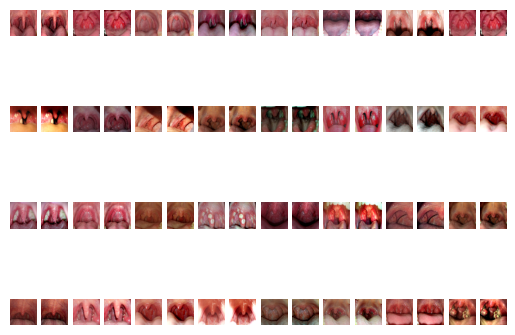

In [7]:
color_corrected_data = data.map(lambda x, y: (color_correct(x), x, y))
for color_corrected_batch, original_batch, label_batch in color_corrected_data.take(1):
    for i in range(32):
        plt.subplot(4, 16, i*2 + 1)
        plt.imshow(original_batch[i]/255.0)
        plt.axis('off')
        plt.subplot(4, 16, i*2 + 2)
        plt.imshow(color_corrected_batch[i]/255.0)
        plt.axis('off')
    plt.show()

## See what rgb color mask does

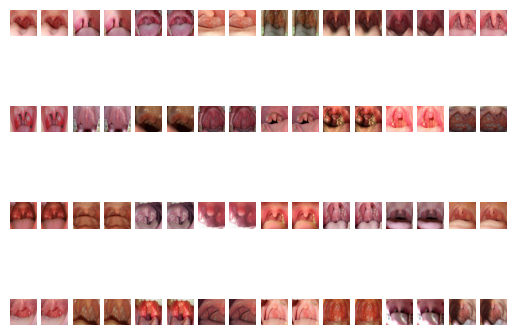

In [8]:
data_masked = data.map(lambda x, y: (color_mask_rgb(x), x, y))
for color_corrected_batch, original_batch, label_batch in data_masked.take(1):
    for i in range(32):
        plt.subplot(4, 16, i*2 + 1)
        plt.imshow(original_batch[i]/255.0)
        plt.axis('off')
        plt.subplot(4, 16, i*2 + 2)
        plt.imshow(color_corrected_batch[i]/255.0)
        plt.axis('off')
    plt.show()

## See what rgb to ycbcr does

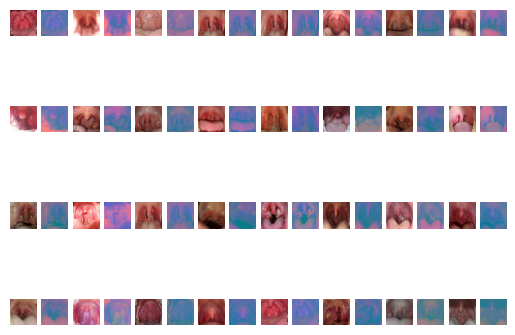

In [9]:
data_ycbcr = data.map(lambda x, y: (rgb_to_ycbcr(x), x, y))
for color_corrected_batch, original_batch, label_batch in data_ycbcr.take(1):
    for i in range(32):
        plt.subplot(4, 16, i*2 + 1)
        plt.imshow(original_batch[i]/255.0)
        plt.axis('off')
        plt.subplot(4, 16, i*2 + 2)
        plt.imshow(color_corrected_batch[i]/255.0)
        plt.axis('off')
    plt.show()

## See what ycbcr color mask does

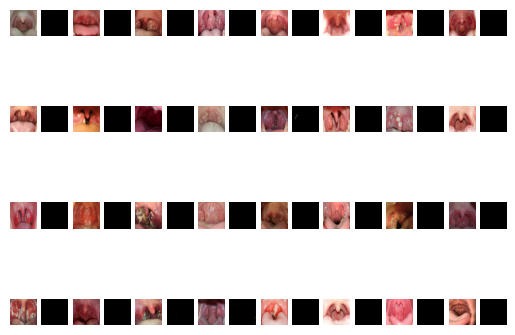

In [10]:
data_masked = data.map(lambda x, y: (color_mask_ycbcr(x), x, y))
for color_corrected_batch, original_batch, label_batch in data_masked.take(1):
    for i in range(32):
        plt.subplot(4, 16, i*2 + 1)
        plt.imshow(original_batch[i]/255.0)
        plt.axis('off')
        plt.subplot(4, 16, i*2 + 2)
        plt.imshow(color_corrected_batch[i]/255.0)
        plt.axis('off')
    plt.show()

## Actually preprocessing data

In [37]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    rescale=1./255
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
# +1 to make sure total is 12 as that was total no. of batches
test_size = int(len(data) * .1) + 1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [28]:
def return_np_array_from_dataset(ds):
    images_list = []
    labels_list = []
    for images, labels in ds.unbatch():
        print(images)
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())
    images_np = np.array(images_list)
    labels_np = np.array(labels_list)
    return images_np, labels_np


train_images_np, train_labels_np = return_np_array_from_dataset(train)
val_images_np, val_labels_np = return_np_array_from_dataset(val)
test_images_np, test_labels_np = return_np_array_from_dataset(test)

tf.Tensor(
[[[211.11426 149.11426 152.11426]
  [209.89062 147.89062 150.89062]
  [207.21875 145.21875 148.21875]
  ...
  [208.35254 149.35254 151.35254]
  [207.45215 148.45215 150.45215]
  [206.55176 147.55176 149.55176]]

 [[212.43848 150.43848 153.43848]
  [211.29688 149.29688 152.29688]
  [209.53613 147.53613 150.53613]
  ...
  [209.      150.      152.     ]
  [208.60938 149.60938 151.60938]
  [208.21875 149.21875 151.21875]]

 [[215.00879 153.00879 156.00879]
  [213.70312 151.70312 154.70312]
  [212.02832 150.02832 153.02832]
  ...
  [210.0127  151.0127  153.0127 ]
  [210.02637 151.02637 153.02637]
  [210.03125 151.03125 153.03125]]

 ...

 [[204.99121 143.02246 154.00684]
  [206.9375  145.33301 153.64062]
  [209.20312 146.23438 154.21875]
  ...
  [216.26562 166.10938 170.5    ]
  [222.30762 184.07812 189.02637]
  [215.64062 182.86816 188.3125 ]]

 [[206.04785 141.87598 153.2666 ]
  [207.5127  143.34082 152.73145]
  [208.39062 144.60938 152.60938]
  ...
  [218.09375 170.78125 174.

In [29]:
train_generator = train_datagen.flow(
    train_images_np,
    train_labels_np,
    shuffle=False,
    batch_size=32
)
val_generator = val_datagen.flow(
    val_images_np,
    val_labels_np,
    shuffle=False,
    batch_size=32
)
test_generator = test_datagen.flow(
    test_images_np,
    test_labels_np,
    shuffle=False,
    batch_size=32
)

## View images and labels generated

0   AxesSubplot(0.125,0.53;0.0407895x0.35)
1   AxesSubplot(0.173947,0.53;0.0407895x0.35)
2   AxesSubplot(0.222895,0.53;0.0407895x0.35)
3   AxesSubplot(0.271842,0.53;0.0407895x0.35)
4   AxesSubplot(0.320789,0.53;0.0407895x0.35)
5   AxesSubplot(0.369737,0.53;0.0407895x0.35)
6   AxesSubplot(0.418684,0.53;0.0407895x0.35)
7   AxesSubplot(0.467632,0.53;0.0407895x0.35)
8   AxesSubplot(0.516579,0.53;0.0407895x0.35)
9   AxesSubplot(0.565526,0.53;0.0407895x0.35)
10   AxesSubplot(0.614474,0.53;0.0407895x0.35)
11   AxesSubplot(0.663421,0.53;0.0407895x0.35)
12   AxesSubplot(0.712368,0.53;0.0407895x0.35)
13   AxesSubplot(0.761316,0.53;0.0407895x0.35)
14   AxesSubplot(0.810263,0.53;0.0407895x0.35)
15   AxesSubplot(0.859211,0.53;0.0407895x0.35)
16   AxesSubplot(0.125,0.11;0.0407895x0.35)
17   AxesSubplot(0.173947,0.11;0.0407895x0.35)
18   AxesSubplot(0.222895,0.11;0.0407895x0.35)
19   AxesSubplot(0.271842,0.11;0.0407895x0.35)
20   AxesSubplot(0.320789,0.11;0.0407895x0.35)
21   AxesSubplot(0.369737,0.1

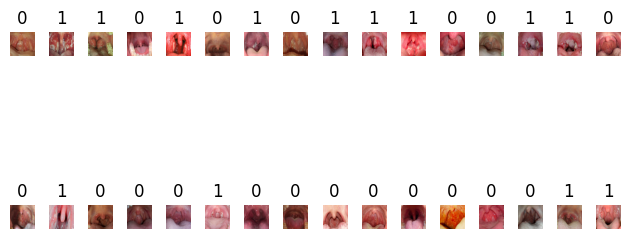

In [36]:
#Change the generator in the next to choose which generator
images_to_show, labels_to_show = next(test_generator)
fig, axes = plt.subplots(nrows=2, ncols=32//2)
for i, ax in enumerate(axes.flatten()):
    print(i, " ", ax)
    ax.imshow(images_to_show[i])
    ax.set_title(f"{labels_to_show[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Building the deep learning model

In [38]:
'''
model = ResNet50(include_top=False, weights='imagenet',
                 input_shape=(256, 256, 3), classes=2, pooling='avg')
resnet_model = Sequential()
resnet_model.add(model)
for layer in resnet_model.layers:
    layer.trainable = False
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.compile('adam', loss=tf.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])
resnet_model.summary()
'''


model = Sequential()
# model.add(resnet_model)
# Conv2D(No. of filters, dimensions of filter, activation function, expected image size(only first time))
model.add(Conv2D(32, (3, 3), 1, activation='relu',
          padding="same", input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())


model.add(Conv2D(32, (3, 3), 1, activation='relu'))

model.add(Conv2D(32, (3, 3), 1, activation='relu', padding="same"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
# model.summary()

## Fitting and testing the model

In [39]:
hist = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/20


2023-03-01 23:14:13.574569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 4s 434ms/step - loss: 0.7465 - accuracy: 0.4922 - val_loss: 0.6919 - val_accuracy: 0.5469
Epoch 2/20


2023-03-01 23:14:17.407414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 3s 385ms/step - loss: 0.6925 - accuracy: 0.5430 - val_loss: 0.6920 - val_accuracy: 0.6406
Epoch 3/20
8/8 [==============================] - 3s 380ms/step - loss: 0.6862 - accuracy: 0.5938 - val_loss: 0.6916 - val_accuracy: 0.5469
Epoch 4/20
8/8 [==============================] - 3s 373ms/step - loss: 0.6749 - accuracy: 0.5938 - val_loss: 0.6867 - val_accuracy: 0.5469
Epoch 5/20
8/8 [==============================] - 3s 375ms/step - loss: 0.6662 - accuracy: 0.6172 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 6/20
8/8 [==============================] - 3s 375ms/step - loss: 0.6415 - accuracy: 0.6562 - val_loss: 0.6551 - val_accuracy: 0.6250
Epoch 7/20
8/8 [==============================] - 3s 380ms/step - loss: 0.5934 - accuracy: 0.6992 - val_loss: 0.6013 - val_accuracy: 0.6875
Epoch 8/20
8/8 [==============================] - 3s 379ms/step - loss: 0.5151 - accuracy: 0.7461 - val_loss: 0.5233 - val_accuracy: 0.7500
Epoch 9/20
8/8 [===============

### Graph for error and accuracy

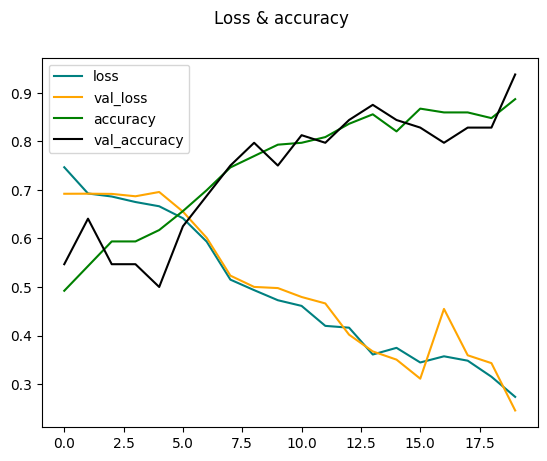

In [40]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_accuracy'],
         color='black', label='val_accuracy')
fig.suptitle('Loss & accuracy')
plt.legend(loc='upper left')
plt.show()

## Evaluation on test set

In [41]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for i in range(2):
    x, y = test_generator.next()
    y_pred = model.predict(x)
    y_hat = []
    for x in y_pred:
        y_hat.append(x[0])
    pre.update_state(y, y_hat)
    re.update_state(y, y_hat)
    acc.update_state(y, y_hat)

print("Precision: ", pre.result().numpy())
print("Recall: ", re.result().numpy())
print("Accuracy: ", acc.result().numpy())

1/1 [==============================] - 0s 172ms/step


2023-03-01 23:15:42.822398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 65ms/step
Precision:  0.9333334
Recall:  0.875
Accuracy:  0.92857146


## Saving the model

In [ ]:
model.save(os.path.join('models', 'tonsil_detector.h5'))